# Preprocessing and Modeling
***

# Installing Packages and Libraries

In [34]:
# Uncomment to upgrade packages
#!pip3 install pandas --user --upgrade --quiet
#!pip3 install scipy --user --upgrade --quiet
#!pip3 install numpy --user --upgrade --quiet
#!pip3 install statsmodels --user --upgrade --quiet
#!pip3 install seaborn --user --upgrade --quiet

In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# extra imports
from pandas import read_csv
from scipy.stats import boxcox, shapiro, chi2, chi2_contingency
from matplotlib import patches
import seaborn as sns

In [41]:
from sklearn.model_selection import train_test_split
import pickle
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
# from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.metrics import make_scorer
from sklearn.svm import LinearSVC

from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
seed = 223344

In [4]:
np.random.seed(666)

[2, 3]

***
# SECTION 1: Reading the Dataset `bank_marketing_new.csv`

In this first part we are going to load the dataset and get a first overview of the available data.

In [6]:
bank_marketing = read_csv("./bank_marketing_new.csv", header=0, delimiter=',')
bank_marketing.head(20)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,previous,y
0,49,business,divorced,1,no,-347,yes,no,Unknown,26,may,2,0,no
1,30,others,single,2,no,-97,yes,no,Unknown,4,jun,2,0,no
2,35,others,married,2,no,513,yes,no,cellular,18,jul,1,0,no
3,34,business,married,2,no,471,yes,no,cellular,8,may,3,2,no
4,47,business,married,2,no,136,yes,no,Unknown,20,may,1,0,no
5,38,business,married,2,no,976,yes,yes,Unknown,19,may,2,0,no
6,43,business,married,2,no,59,no,no,Unknown,13,may,2,0,no
7,37,others,married,2,no,1328,yes,no,cellular,14,jul,3,0,no
8,59,others,married,1,no,495,no,no,Unknown,5,jun,2,0,no
9,40,business,married,3,no,1213,no,no,cellular,4,aug,1,0,no


As we can see, the dataset has **4019** observations and **21** columns (variables). Our target value is the `Status` of the patient and it can be binary (Dead or Alive).

In [7]:
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43621 entries, 0 to 43620
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        43621 non-null  int64 
 1   job        43621 non-null  object
 2   marital    43621 non-null  object
 3   education  43621 non-null  int64 
 4   default    43621 non-null  object
 5   balance    43621 non-null  int64 
 6   housing    43621 non-null  object
 7   loan       43621 non-null  object
 8   contact    43621 non-null  object
 9   day        43621 non-null  int64 
 10  month      43621 non-null  object
 11  campaign   43621 non-null  int64 
 12  previous   43621 non-null  int64 
 13  y          43621 non-null  object
dtypes: int64(6), object(8)
memory usage: 4.7+ MB


Below we can see the first 5 rows of the dataset in order to have a brief overview of the available data.

In [8]:
bank_marketing.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,previous,y
count,43621.000000,43621,43621,43621.000000,43621,43621.000000,43621,43621,43621,43621.000000,43621,43621.000000,43621.000000,43621
unique,NaN,2,3,NaN,2,NaN,2,2,3,NaN,12,NaN,NaN,2
top,NaN,others,married,NaN,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,no
freq,NaN,27994,26237,NaN,42847,NaN,24288,36677,28350,NaN,13481,NaN,NaN,38408
mean,40.947342,NaN,NaN,2.148208,NaN,1368.332477,NaN,NaN,NaN,15.622659,NaN,2.333555,0.528851,NaN
std,10.649712,NaN,NaN,0.664810,NaN,3048.214243,NaN,NaN,NaN,8.268917,NaN,1.672777,1.499801,NaN
min,18.000000,NaN,NaN,1.000000,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,0.000000,NaN
25%,33.000000,NaN,NaN,2.000000,NaN,75.000000,NaN,NaN,NaN,8.000000,NaN,1.000000,0.000000,NaN
50%,39.000000,NaN,NaN,2.000000,NaN,454.000000,NaN,NaN,NaN,16.000000,NaN,2.000000,0.000000,NaN
75%,48.000000,NaN,NaN,3.000000,NaN,1434.000000,NaN,NaN,NaN,21.000000,NaN,3.000000,0.000000,NaN


# SECTION 2: Categorical vars preprocessing

In [9]:
#Boolean yes,no to 1,0

yes_no_mapping = {'yes':1, 'no': 0}
bank_marketing['default'] = bank_marketing['default'].map(yes_no_mapping)
bank_marketing['housing'] = bank_marketing['housing'].map(yes_no_mapping)
bank_marketing['loan'] = bank_marketing['loan'].map(yes_no_mapping)
bank_marketing['y'] = bank_marketing['y'].map(yes_no_mapping)

yes_no_mapping = {'business':1, 'others': 0}
bank_marketing['job'] = bank_marketing['job'].map(yes_no_mapping)



In [10]:
bank_marketing.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,previous,y
0,49,1,divorced,1,0,-347,1,0,Unknown,26,may,2,0,0
1,30,0,single,2,0,-97,1,0,Unknown,4,jun,2,0,0
2,35,0,married,2,0,513,1,0,cellular,18,jul,1,0,0
3,34,1,married,2,0,471,1,0,cellular,8,may,3,2,0
4,47,1,married,2,0,136,1,0,Unknown,20,may,1,0,0
5,38,1,married,2,0,976,1,1,Unknown,19,may,2,0,0
6,43,1,married,2,0,59,0,0,Unknown,13,may,2,0,0
7,37,0,married,2,0,1328,1,0,cellular,14,jul,3,0,0
8,59,0,married,1,0,495,0,0,Unknown,5,jun,2,0,0
9,40,1,married,3,0,1213,0,0,cellular,4,aug,1,0,0


In [11]:
#One_hot_encoding multicategorical

X = bank_marketing
categorical_columns =X.dtypes[X.dtypes == 'object'].index.values
for column in categorical_columns:
    X_one_hot = pd.get_dummies(X[column], prefix=column)
    X_one_hot = X_one_hot.astype(int)  # Convert True/False to 1/0
    X = pd.concat([X, X_one_hot], axis=1)  # Concatenate the one-hot encoded columns to the original DataFrame
    X = X.drop(columns=[column])  # Drop the original categorical column

    
bank_marketing = X
# Example: Display the first few rows of the modified DataFrame
bank_marketing.columns

Index(['age', 'job', 'education', 'default', 'balance', 'housing', 'loan',
       'day', 'campaign', 'previous', 'y', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_Unknown',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep'],
      dtype='object')

***
# SECTION 3: Dataset Splits

## Resampling Protocol
In order to start the modeling process it is very important to split the dataset into training and test sets.

We will use two data partitions (`train` and `test`) and later on we will apply cross-validation over the train partition for deciding hyperparameters.

In [31]:
X = bank_marketing.loc[:, bank_marketing.columns != 'y']
y = bank_marketing['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [32]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(43621, 28)
(34896, 28)
(8725, 28)
(34896,)
(8725,)


In [34]:
y_train.value_counts()

y
0    30741
1     4155
Name: count, dtype: int64

# SECTION 4: Numerical vars normalization

In [15]:
def minmaxscaling(X, y, scaler=None):
    
    # Scale numerical variables
    if scaler is None: 
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    else: 
        X = scaler.transform(X)
    
    return X, y, scaler


X_train, y_train, scaler = minmaxscaling(X_train,y_train)
X_test, y_test, _ = minmaxscaling(X_test,y_test,scaler)

In [16]:
dataframe = pd.DataFrame(X_train)
dataframe

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.184211,0.0,0.0,0.0,0.068682,1.0,1.0,0.566667,0.500,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.184211,1.0,1.0,0.0,0.099886,1.0,0.0,0.366667,0.000,0.071429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.289474,0.0,1.0,0.0,0.073702,0.0,0.0,0.400000,0.125,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.144737,0.0,0.0,0.0,0.082027,1.0,0.0,0.866667,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.381579,1.0,1.0,0.0,0.083625,1.0,0.0,0.466667,0.125,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34891,0.223684,0.0,1.0,0.0,0.072858,1.0,1.0,0.500000,0.125,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34892,0.421053,1.0,0.5,0.0,0.076961,0.0,0.0,0.066667,0.250,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34893,0.500000,1.0,0.5,0.0,0.091751,1.0,0.0,0.366667,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
34894,0.157895,1.0,1.0,0.0,0.076435,1.0,0.0,0.200000,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
# Save preprocessed training set to CSV
# X_train.to_csv('preprocessed_train.csv', index=False)
# y_train.to_csv('preprocessed_train_labels.csv', index=False)

***
# SECTION 4: Modeling

## Linear SVC

In [18]:
import time
start_time = time.time()

# Primal, n_features < n_samples
model = svm.LinearSVC(dual=bool(0)).fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time

0.07173514366149902

In [19]:
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Model Accuracy: 0.88


<Figure size 400x300 with 0 Axes>

<Axes: >

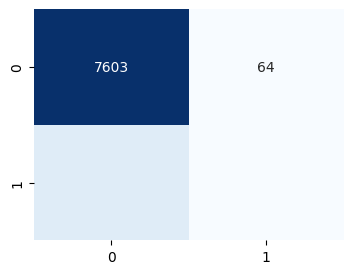

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

In [21]:
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Calculate the F1 score for each class and the overall weighted average
f1_scores = f1_score(y_test, y_pred, average=None)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

# Print the F1 scores for each class
print("F1 Scores (Per Class):")
for idx, f1 in enumerate(f1_scores):
    print(f"Class {idx}: {f1}")

# Print the overall weighted F1 score
print("Weighted F1 Score:", weighted_f1)

Confusion Matrix:
[[7603   64]
 [ 969   89]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      7667
           1       0.58      0.08      0.15      1058

    accuracy                           0.88      8725
   macro avg       0.73      0.54      0.54      8725
weighted avg       0.85      0.88      0.84      8725

F1 Scores (Per Class):
Class 0: 0.9363877086027464
Class 1: 0.14698596201486375
Weighted F1 Score: 0.8406642647185081


In [ ]:
##not good for yes instances, NEXT DO UNDERSAMPLING AND SEE

## Kernelized SVC: Gaussian Radial Basis

In [22]:
import time
start_time = time.time()


kernel = "rbf"
sigma = "auto"
model = svm.SVC(kernel=kernel, gamma=sigma).fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time

9.613254308700562

Model Accuracy: 0.88


<Figure size 400x300 with 0 Axes>

<Axes: >

Confusion Matrix:
[[7615   52]
 [ 997   61]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.94      7667
           1       0.54      0.06      0.10      1058

    accuracy                           0.88      8725
   macro avg       0.71      0.53      0.52      8725
weighted avg       0.84      0.88      0.83      8725

F1 Scores (Per Class):
Class 0: 0.9355611524049388
Class 1: 0.10418445772843724
Weighted F1 Score: 0.8347477950447395


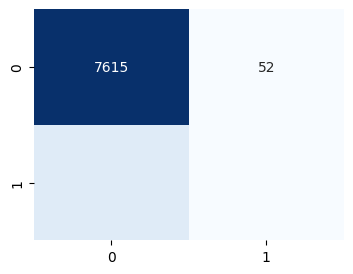

In [23]:
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Calculate the F1 score for each class and the overall weighted average
f1_scores = f1_score(y_test, y_pred, average=None)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

# Print the F1 scores for each class
print("F1 Scores (Per Class):")
for idx, f1 in enumerate(f1_scores):
    print(f"Class {idx}: {f1}")

# Print the overall weighted F1 score
print("Weighted F1 Score:", weighted_f1)

As we can see, neither the Linear or Kernelized SVC achieve a better `accuracy` than a dummy model always predicting "no", given we have 87% of "no", and only improves the overall `f1-score` by getting a small amount of "yes" right and maintaining 88% accuracy. Nonetheless, a 6% of recall on the "yes" is still very poor.

We decided to try undersampling the amount of "no" instances in our training set and retry our SVM trainings.

## Undersampling modeling

In [70]:

def undersample (X,y):
    majority_indices_train = y[y == 0].index
    minority_indices_train = y[y == 1].index

    undersampled_majority_indices_train = resample(majority_indices_train,
                                             replace=False,
                                             n_samples=sum(y == 1),
                                             random_state=42)

    # Concatenate undersampled majority indices with minority indices
    undersampled_indices_train = pd.Index(undersampled_majority_indices_train).union(minority_indices_train)

    # Use the undersampled indices to create undersampled datasets
    X_undersampled = X.loc[undersampled_indices_train]
    y_undersampled = y.loc[undersampled_indices_train]
    
    print(X_undersampled.shape, '\n',y_undersampled.value_counts())
    return X_undersampled, y_undersampled


In [72]:

X_undersampled_train, y_undersampled_train = undersample(X_train, y_train)
X_undersampled_test, y_undersampled_test = undersample(X_test, y_test)

(8310, 28) 
 y
1    4155
0    4155
Name: count, dtype: int64
(2116, 28) 
 y
0    1058
1    1058
Name: count, dtype: int64


## Linear SVC


In [73]:
import time
start_time = time.time()

# Primal, n_features < n_samples
model = svm.LinearSVC(dual=bool(0)).fit(X_undersampled_train, y_undersampled_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)


0.03050708770751953


Model Accuracy: 0.68


<Figure size 400x300 with 0 Axes>

<Axes: >

Confusion Matrix:
[[709 349]
 [326 732]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1058
           1       0.68      0.69      0.68      1058

    accuracy                           0.68      2116
   macro avg       0.68      0.68      0.68      2116
weighted avg       0.68      0.68      0.68      2116

F1 Scores (Per Class):
Class 0: 0.6774964166268513
Class 1: 0.6844319775596073
Weighted F1 Score: 0.6809641970932293


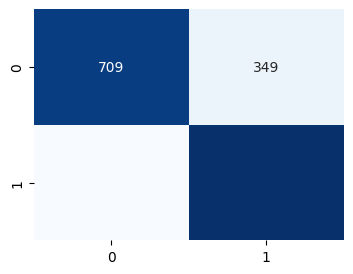

In [76]:
y_pred = model.predict(X_undersampled_test)
print(f"Model Accuracy: {accuracy_score(y_undersampled_test, y_pred):.2f}")

conf_matrix = confusion_matrix(y_undersampled_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print the classification report
report = classification_report(y_undersampled_test, y_pred)
print("Classification Report:")
print(report)

# Calculate the F1 score for each class and the overall weighted average
f1_scores = f1_score(y_undersampled_test, y_pred, average=None)
weighted_f1 = f1_score(y_undersampled_test, y_pred, average='weighted')

# Print the F1 scores for each class
print("F1 Scores (Per Class):")
for idx, f1 in enumerate(f1_scores):
    print(f"Class {idx}: {f1}")

# Print the overall weighted F1 score
print("Weighted F1 Score:", weighted_f1)

## GRBF 

In [77]:
import time
start_time = time.time()


kernel = "rbf"
sigma = "auto"
model = svm.SVC(kernel=kernel, gamma=sigma).fit(X_undersampled_train, y_undersampled_train)

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time

3.2386374473571777

### Evaluation undersampled test set

Model Accuracy: 0.60


<Figure size 400x300 with 0 Axes>

<Axes: >

Confusion Matrix:
[[548 510]
 [343 715]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.52      0.56      1058
           1       0.58      0.68      0.63      1058

    accuracy                           0.60      2116
   macro avg       0.60      0.60      0.59      2116
weighted avg       0.60      0.60      0.59      2116

F1 Scores (Per Class):
Class 0: 0.5623396613648024
Class 1: 0.6263688129653964
Weighted F1 Score: 0.5943542371650994


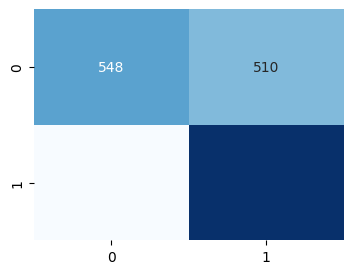

In [81]:
y_pred = model.predict(X_undersampled_test)
print(f"Model Accuracy: {accuracy_score(y_undersampled_test, y_pred):.2f}")

conf_matrix = confusion_matrix(y_undersampled_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print the classification report
report = classification_report(y_undersampled_test, y_pred)
print("Classification Report:")
print(report)

# Calculate the F1 score for each class and the overall weighted average
f1_scores = f1_score(y_undersampled_test, y_pred, average=None)
weighted_f1 = f1_score(y_undersampled_test, y_pred, average='weighted')

# Print the F1 scores for each class
print("F1 Scores (Per Class):")
for idx, f1 in enumerate(f1_scores):
    print(f"Class {idx}: {f1}")

# Print the overall weighted F1 score
print("Weighted F1 Score:", weighted_f1)

### Evaluation original test set

Model Accuracy: 0.55


<Figure size 400x300 with 0 Axes>

<Axes: >

Confusion Matrix:
[[4071 3596]
 [ 343  715]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.53      0.67      7667
           1       0.17      0.68      0.27      1058

    accuracy                           0.55      8725
   macro avg       0.54      0.60      0.47      8725
weighted avg       0.83      0.55      0.62      8725

F1 Scores (Per Class):
Class 0: 0.6739508318847778
Class 1: 0.26634382566585957
Weighted F1 Score: 0.6245241026492918


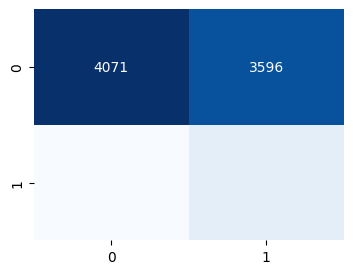

In [83]:
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate and print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Calculate the F1 score for each class and the overall weighted average
f1_scores = f1_score(y_test, y_pred, average=None)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

# Print the F1 scores for each class
print("F1 Scores (Per Class):")
for idx, f1 in enumerate(f1_scores):
    print(f"Class {idx}: {f1}")

# Print the overall weighted F1 score
print("Weighted F1 Score:", weighted_f1)

## Cross-Validation, Model-Comparison & Hyper-parameter Tuning

In [53]:
np.random.seed(666)

# Apply Random Oversampling to balance the dataset
oversampler = RandomOverSampler()
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Define the models and their hyperparameter grids
models = {
    'Logistic Regression': (LogisticRegression(solver='liblinear'), {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10],'class_weight': [None,'balanced']}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [5, 10],'class_weight': [None, 'balanced']}),
    'SVM': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'class_weight': ['balanced']}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.01, 0.001],}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [5, 10], 'min_samples_split': [2, 5, 10],'class_weight': [None, 'balanced']}),
    'Naive Bayes': (GaussianNB(), {}),
}

# Define a custom scoring function to calculate precision, recall, F1-score
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label='Alive'),
    'recall': make_scorer(recall_score, pos_label='Alive'),
    'f1_score': make_scorer(f1_score, pos_label='Alive')
}

# Perform cross-validation and hyperparameter tuning for each model
results = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit='accuracy')
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Get the mean cross-validated scores for each metric
    cv_results = grid_search.cv_results_
    mean_scores = {
        'Accuracy': cv_results['mean_test_accuracy'][grid_search.best_index_],
        'Precision': cv_results['mean_test_precision'][grid_search.best_index_],
        'Recall': cv_results['mean_test_recall'][grid_search.best_index_],
        'F1-score': cv_results['mean_test_f1_score'][grid_search.best_index_]
    }
    
    results[model_name] = {
        'Best Hyperparameters': grid_search.best_params_,
        **mean_scores,
        'Validation Errors': cv_results['std_test_accuracy'][grid_search.best_index_]
    }

# Create a dataframe to store the results
df_results = pd.DataFrame(results).transpose()
df_results.index.name = 'Model'

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=Alive),
                      'precision': make_scorer(precision_score, pos_label=Alive),
                      'recall': make_scorer(recall_score, pos_label=Alive)})

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [5, 10],
                         'n_estimators': [100, 200, 300]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=Alive),
                      'precision': make_scorer(precision_score, pos_label=Alive),
                      'recall': make_scorer(recall_score, pos_label=Alive)})

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'class_weight': ['balanced'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=Alive),
                      'precision': make_scorer(precision_score, pos_label=Alive),
                      'recall': make_scorer(recall_score, pos_label=Alive)})

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [100, 200, 300]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=Alive),
                      'precision': make_scorer(precision_score, pos_label=Alive),
                      'recall': make_scorer(recall_score, pos_label=Alive)})

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=Alive),
                      'precision': make_scorer(precision_score, pos_label=Alive),
                      'recall': make_scorer(recall_score, pos_label=Alive)})

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [5, 10],
                         'min_samples_split': [2, 5, 10]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=Alive),
                      'precision': make_scorer(precision_score, pos_label=Alive),
                      'recall': make_scorer(recall_score, pos_label=Alive)})

GridSearchCV(cv=5, estimator=GaussianNB(), param_grid={}, refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, pos_label=Alive),
                      'precision': make_scorer(precision_score, pos_label=Alive),
                      'recall': make_scorer(recall_score, pos_label=Alive)})

In [54]:
df_results

,Best Hyperparameters,Accuracy,Precision,Recall,F1-score,Validation Errors
Model,,,,,,
Logistic Regression,"{'C': 1, 'class_weight': None, 'penalty': 'l1'}",0.797103,0.792764,0.804576,0.79855,0.010134
Random Forest,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.915019,0.909497,0.921833,0.915568,0.011617
SVM,"{'C': 10, 'class_weight': 'balanced', 'kernel'...",0.855073,0.864324,0.842774,0.853282,0.006828
Gradient Boosting,"{'learning_rate': 0.1, 'n_estimators': 300}",0.901186,0.913674,0.886262,0.899721,0.013388
KNN,"{'n_neighbors': 3, 'weights': 'distance'}",0.901844,0.998383,0.805011,0.891281,0.005844
Decision Tree,"{'class_weight': None, 'max_depth': 10, 'min_s...",0.87725,0.89786,0.852016,0.873843,0.013492
Naive Bayes,{},0.684454,0.639645,0.845414,0.728181,0.00606


From the results of the `Cross-Validation` procedure, it is concluded that the most appropriate model for the specific use-case seems to be the `Random Forest` which achieves the highest value of `Recall` and `F1-score` respectively. It is really important, in this case, to achieve a high `Recall` value, since the model's goal is to classify unseen (future) patients with `Breast Cancer` into `Alive` or `Dead` cases.

In [55]:
df_results['Best Hyperparameters']['Random Forest']

{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 200}


## Final Model

### Training-Test Error Analysis on the max_depth Parameter

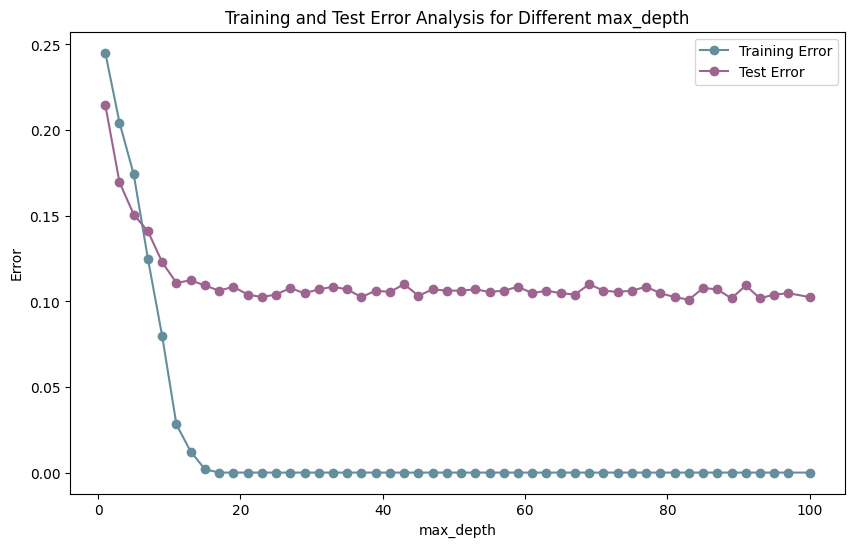

In [66]:
colors = ['#648E9C', '#9C648E']
# Generate 25 different values for max_depth
max_depth_values = np.linspace(1, 100, num=50, dtype=int)

# Initialize lists to store training and test errors
train_errors = []
test_errors = []

# Fit the model and calculate errors for different max_depth values
for max_depth in max_depth_values:
    # Create and fit the Random Forest model with the current max_depth value
    best_rf_model = RandomForestClassifier(class_weight='balanced', max_depth=max_depth, n_estimators=200)
    best_rf_model.fit(X_train_resampled, y_train_resampled);
    
    # Calculate training error
    train_pred = best_rf_model.predict(X_train_resampled)
    train_error = zero_one_loss(y_train_resampled, train_pred)
    train_errors.append(train_error)
    
    # Calculate test error
    test_pred = best_rf_model.predict(X_test)
    test_error = zero_one_loss(y_test, test_pred)
    test_errors.append(test_error)

# Plot the training and test errors
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_errors, marker='o', color=colors[0], label='Training Error')
plt.plot(max_depth_values, test_errors, marker='o', color=colors[1], label='Test Error')
plt.xlabel('max_depth')
plt.ylabel('Error')
plt.title('Training and Test Error Analysis for Different max_depth')
plt.legend()
plt.show();


Here it is obvious that when the parameter `max_depth` of the model exceeds a certain threshold (approx. **11**), the model is overfitting the data, leading to very small `training error` while the `test error` remains steady, or slightly increases. For that reason, we will try to train the algorithm with `max_depth` value equal to around **8** which seems *`just-right`*.

### Training-Test Error Analysis on the n_estimators Parameter

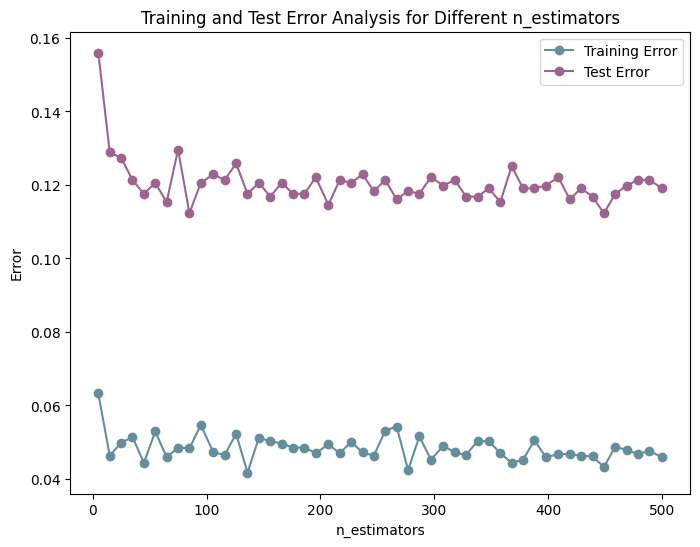

In [67]:
# Generate 25 different values for n_estimators
n_estimators_values = np.linspace(5, 500, num=50, dtype=int)

# Initialize lists to store training and test errors
train_errors = []
test_errors = []

# Fit the model and calculate errors for different n_estimators values
for n_estimators in n_estimators_values:
    # Create and fit the Random Forest model with the current n_estimators value
    best_rf_model = RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=n_estimators)
    best_rf_model.fit(X_train_resampled, y_train_resampled)
    
    # Calculate training error
    train_pred = best_rf_model.predict(X_train_resampled)
    train_error = zero_one_loss(y_train_resampled, train_pred)
    train_errors.append(train_error)
    
    # Calculate test error
    test_pred = best_rf_model.predict(X_test)
    test_error = zero_one_loss(y_test, test_pred)
    test_errors.append(test_error)

# Plot the training and test errors
plt.figure(figsize=(8, 6))
plt.plot(n_estimators_values, train_errors, marker='o', color=colors[0], label='Training Error')
plt.plot(n_estimators_values, test_errors, marker='o', color=colors[1], label='Test Error')
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.title('Training and Test Error Analysis for Different n_estimators')
plt.legend()
plt.show();

As for the `n_estimators` parameter of the model, the result is not so obvious. It seems that over the whole range of the parameter, from **5** to **500**,  both the `training error` and the `test error` remain approximately constant. Thus a clear conclusion cannot be made from this figure.

### Training-Test Error Analysis on the Training Data Size

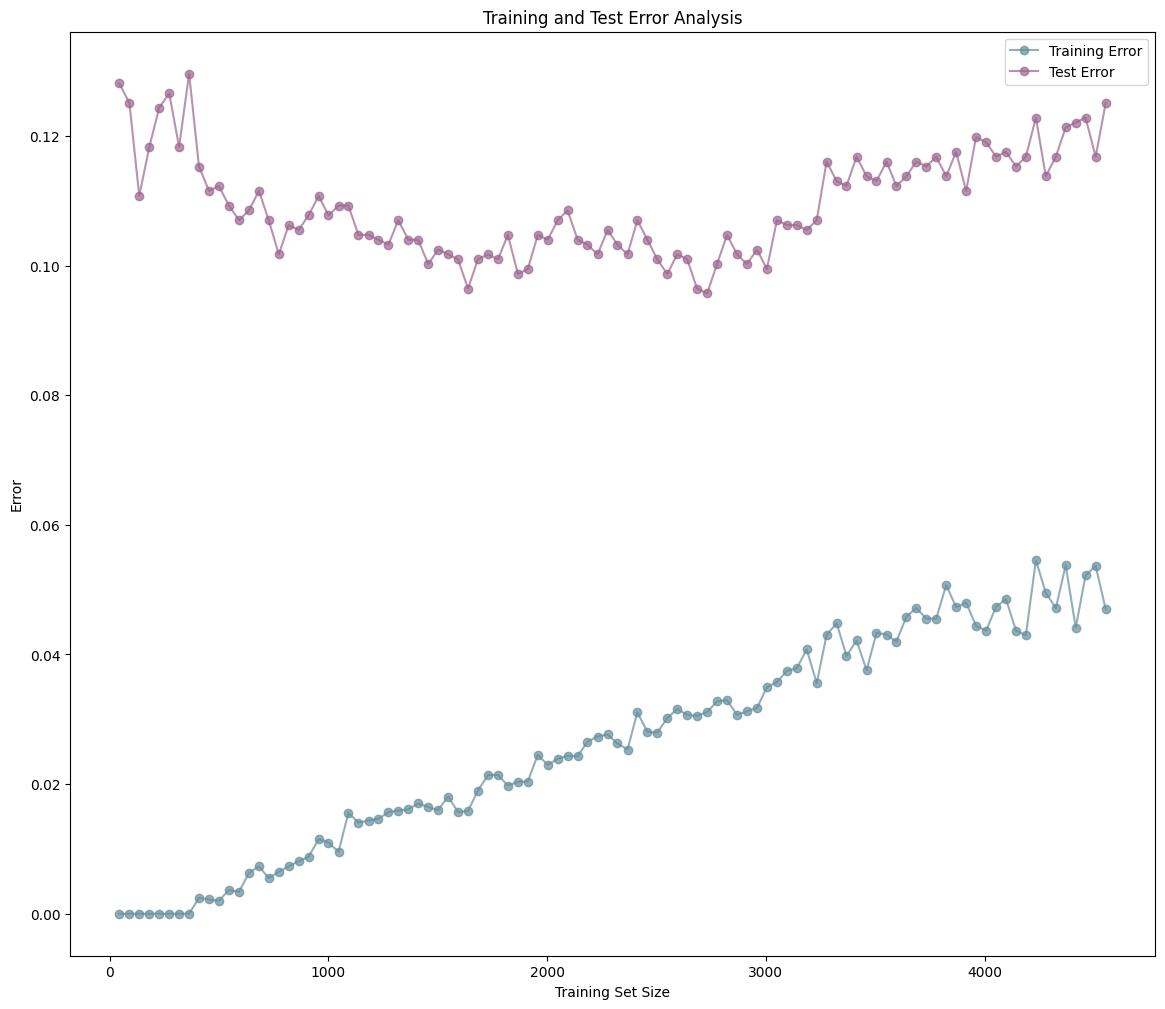

In [69]:
# Define the best hyperparameters for Random Forest
best_rf_params = {'class_weight': 'balanced','max_depth': 10, 'n_estimators': 200}

# Create and fit the best Random Forest model
best_rf_model = RandomForestClassifier(**best_rf_params)

# Initialize lists to store training and test errors
train_errors = []
test_errors = []
train_sizes = []

# Vary the size of the training set
for i in range(1, 101, 1):
    train_size = int((i / 100) * len(X_train_resampled))
    train_sizes.append(train_size)
    
    # Fit the model on the current training set size
    best_rf_model.fit(X_train_resampled[:train_size], y_train_resampled[:train_size])
    
    # Calculate training error
    train_pred = best_rf_model.predict(X_train_resampled[:train_size])
    train_error = zero_one_loss(y_train_resampled[:train_size], train_pred)
    train_errors.append(train_error)
    
    # Calculate test error
    test_pred = best_rf_model.predict(X_test)
    test_error = zero_one_loss(y_test, test_pred)
    test_errors.append(test_error)

# Plot the training and test errors
plt.figure(figsize=(14, 12))
plt.plot(train_sizes, train_errors, marker='o', alpha=0.7, color=colors[0], label='Training Error')
plt.plot(train_sizes, test_errors, marker='o', alpha=0.7, color=colors[1], label='Test Error')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Training and Test Error Analysis')
plt.legend()
plt.show();

From this plot, one can understand that as the `Training Set Size` which is fed into the model increases, the `training misslcassification error` increases but very slightly, since the worst error achieved is approx. 0.06. As for the `test misslcassification error`, it is clear that in fluctuates between the values **0.10** and **0.12**. However, the slopes of the figure suggest that by increasing the total size of the dataset, would lead the two curves to come closer and closer, meaning that the model would be able to generalize pretty-well.

### Final Performace Metrics

Although, previously it was mentioned that a value of **8** for the variable `max_depth` might lead to a more robust solution, for now, we consider keeping it equal to 10, since we retrieve better results on the unseen dataset. However, in future work this might need to be investigated further.

Random Forest Classifier - Test Results
---------------------------------
Accuracy: 0.8809
Precision: 0.9361
Recall: 0.9228
F1-score: 0.9294
---------------------------------
Confusion Matrix:
Predicted Value  Alive  Dead
True Value                  
Alive             1040    87
Dead                71   129


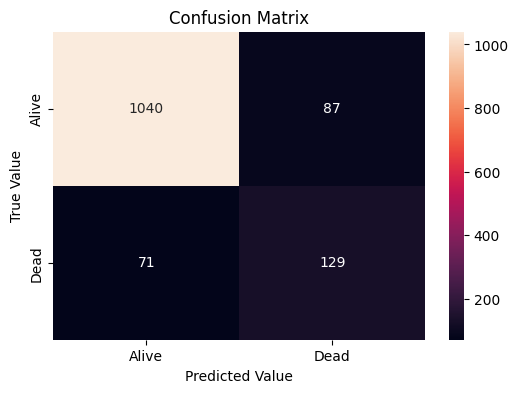

In [59]:
# Define the best hyperparameters for Random Forest
best_rf_params = {'class_weight': 'balanced','max_depth': 10, 'n_estimators': 200}

# Create and fit the best Random Forest model
best_rf_model = RandomForestClassifier(**best_rf_params)

# Fit the model and obtain the training and validation loss
best_rf_model.fit(X_train_resampled, y_train_resampled)

# Use the fitted model to make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the performance of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Alive')
recall = recall_score(y_test, y_pred, pos_label='Alive')
f1 = f1_score(y_test, y_pred, pos_label='Alive')
confusion_mat = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['Alive', 'Dead']

# Create a labeled confusion matrix with indicators
confusion_mat_labeled = pd.DataFrame(confusion_mat, index=class_labels, columns=class_labels)
confusion_mat_labeled.index.name = 'True Value'
confusion_mat_labeled.columns.name = 'Predicted Value'

# Print the performance metrics and labeled confusion matrix
print("Random Forest Classifier - Test Results")
print("---------------------------------")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("---------------------------------")
print("Confusion Matrix:")
print(confusion_mat_labeled)


# Plot the labeled confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat_labeled, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show();


### Interpretability of the Final Model

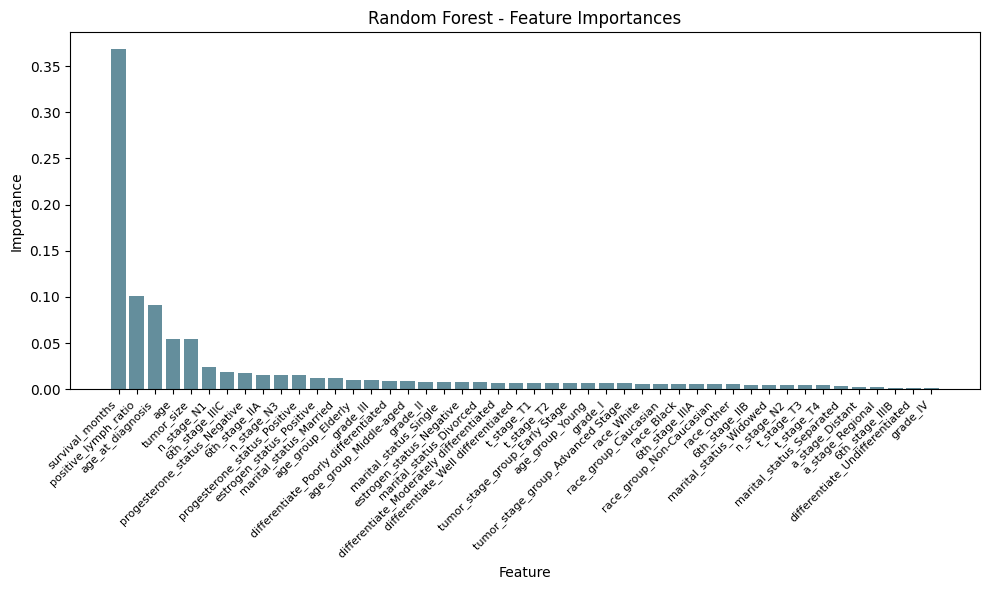

In [60]:
# Get feature importances from the best Random Forest model
feature_importances = best_rf_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]

# Get the names of the features
feature_names = X_train.columns[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), sorted_feature_importances, color='#648E9C')
plt.xticks(range(len(feature_importances)), feature_names, rotation=45, ha='right', fontsize=8)
plt.title('Random Forest - Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show();

From this figure, it is clear that the most important feature included in the final model is by far `survival_months`. Following by, `positive_lymph_ratio` and `age_at_diagnosis` play a crucial role in the predictability power of the model. Moreover, `tumor_size` and `n_stage_N1` offer discrimination power to the learning algorithm enabling it to distinguish between `Alive` and `Dead` cases. Lastly, `n_stage_N3`, `progesterone_status_negative`, `6th_stage_ICC` and `progesterone_status_negative` are the next in the feature importance list. The rest of the variables contribute quite less than the mentioned ones.

Important notes to mention here is:
- It is obvious that there is some overlap between specific variables used during the training of the algorithm (`age` and `age_at_diagnosis`)
- Some of the categories included in the architecture, do not contribute as much in deriving decisions on unseen data.
    - However, since in this case the computation power needed to fit the algorithm and perform computational expensive processes such as Cross-Validation, was clearly bearable, we did not pay special attention to reduce the dimensionality of the model.
    - Although, dimensionality techniques, such as `PCA/MCA/MFA` would solve this problem, and would make the size and complexity of the model drop.
    - Also with the following commands, it is easy to see (from the `csv` file `chi-2-2`) which categories of the categorical variables are statistically correlated.

In [61]:
_, cat_cols = split_cat_num_columns(X_train)
chi_squared_results = perform_chi_squared_test(X_train, cat_cols)

In [62]:
# Filter out duplicate rows
chi_squared_results_unique = chi_squared_results[chi_squared_results['P-value'] < 0.05]

# Sort Variable 1 and Variable 2 in each row
sorted_variables = np.sort(chi_squared_results_unique[['Variable 1', 'Variable 2']], axis=1)
chi_squared_results_unique.loc[:, ['Variable 1', 'Variable 2']] = sorted_variables

# Drop duplicate rows
chi_squared_results_unique = chi_squared_results_unique.drop_duplicates(subset=['Variable 1', 'Variable 2'])

# Save the results to a CSV file
chi_squared_results_unique.to_csv("./chi-2-2.csv", index=False)

In [63]:
# from sklearn import tree
# # Get the list of all trees in the Random Forest
# trees = best_rf_model.estimators_

# # Plot all the trees
# for i, tree_estimator in enumerate(trees):
#     plt.figure(figsize=(10, 6))
#     tree.plot_tree(tree_estimator, feature_names=X_train.columns, filled=True)
#     plt.title("Tree {}".format(i+1))
#     plt.show();

### Saving the Final Model

In [64]:
# Save the best_rf_model to a file
with open("best_rf_model.pkl", "wb") as file:
    pickle.dump(best_rf_model, file)